In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

In [4]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
#df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
#df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

#td = df.duration.iloc[0]
#td.total_seconds()

# filter
df = df[(df.duration >= 1) & (df.duration <= 60)]

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 100.0)

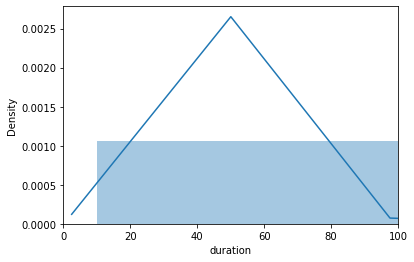

In [59]:
#sns.distplot(df.duration, bins=10)
#plt.xlim(0, 100)

In [55]:
#df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1.730935e+06
mean     2.229389e+01
std      4.437318e+01
min      1.001667e+01
50%      1.710000e+01
95%      4.565000e+01
98%      5.838333e+01
99%      6.816667e+01
max      9.455400e+03
Name: duration, dtype: float64

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical].dtypes
df[categorical] = df[categorical].astype(str) #int -> str


In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
#DataFrame에서 범주형(categorical)과 수치형(numerical) 컬럼만 선택해, 각 행을 딕셔너리로 변환합니다.
#결과는 딕셔너리의 리스트가 됩니다. (예: [{'col1': val1, 'col2': val2, ...}, ...])

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

#DictVectorizer는 딕셔너리 형태의 데이터를 머신러닝 모델이 사용할 수 있는 행렬(벡터)로 변환합니다.
#fit_transform은 학습과 변환을 동시에 수행합니다.
#X_train은 변환된 특성 행렬(2차원 배열, sparse matrix)입니다.

target = 'duration'
y_train = df[target].values
#예측하고자 하는 목표값(여기서는 'duration' 컬럼)을 y_train에 저장합니다.

lr = LinearRegression()
lr.fit(X_train, y_train)
#선형회귀 모델을 생성하고, X_train(특성)과 y_train(목표값)으로 학습시킵니다.

y_pred = lr.predict(X_train)
#학습된 모델로 X_train에 대한 예측값을 구합니다.


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


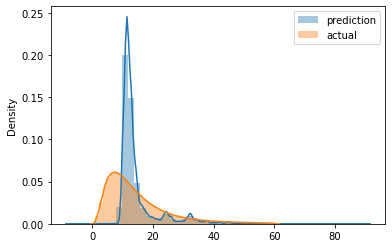

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()